<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-10-02' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "8908079" #@param {type:"string"}
Student_full_name = "Morgan Lynch" #@param {type:"string"}
#@markdown ---

# INTRODUCTION

This Etivity aims to use piecewise regression to predict house prices. Initially regression is used across the full dataset and then this is compared to a piecewise approach.



## Dataset
The data was first imported from CSV and processed to remove unecessary and textual columns. The distributions were then checked and outliers were removed.
Several columns such as bedrooms and bathrooms had empty values, so these rows were also removed. The final columns after pre-processing are listed below:


| Column | Processing |
| --- | ---|
| ad_id	| Removed |
| area | Removed |
| bathrooms | Outliers and Nulls Removed |
| beds	| Outliers and Nulls Removed |
| ber_classification | Removed |
| county | Removed |
| description_block | Removed |
| environment | Removed	
| facility | Removed - Textual  |
| features | Removed - Textual |
| latitude | Outliers and Nulls Removed |
| longitude  | Outliers and Nulls Removed |
| no_of_units | Removed  |
| property_category | One Hot Encoded |
| property_type	| One Hot Encoded |
| surface | Nulls Removed  |
| price	| Nulls removed  |

Initially a heatmap was used to try to identigy significant relationships between the features. From this a number of significant columns were selected. These were: beds, bathrooms, latitude, longitude, surface and price.

## Method

From the processed data, several columns were then selected and scaled. These were then processed in full and both mean absolute error (MAE) and mean absolute percentage error (MAPE) were calculated (Regression error metrics, Dataquest 2021).

Using k-means clustering in a range of 3 to 10 clusters, the level of distortion was plotted for each value of K. A suitable elbow was found between 5 and 6 clusters.

The data was then segmented into these 6 clusters and this regression repeated for each. This approach is Piecewise regression and it is used to apply linear regression seperately on to several segments. The goal of this approach is to determine if the data follows different teends within different areas of the data (Piecewise linear regression, Towards Data Science, 2021).

Finally, the model was applied to the test dataset and repeated once more.

# DATASET

## Imports

In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [5]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [6]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

## Shared Functions

In [8]:
#Shared functions

#Describe a dataframe
def describe_data(df_name,df):
  output= f"Name:{df_name}\n"
  output+=f"Shape:{df.shape}\n"
  output+=f"Head:\n{df.head(3).to_string()}\n\n"
  output+=f"Describe:\n{df.describe().to_string()}\n"
  output+="-----------------------------------------------------------------------"
  output+="\n\n"
  return output

#Encode categorical data into numeric
def make_numeric(df,column):
  lb_make = LabelEncoder()
  df[column+"_num"] = lb_make.fit_transform(df[column])
  return df

#Plot the detail of a column
def plotColumn(df, column):
    fig = plt.figure(figsize=(20,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    df[column].hist(bins=50)
    #
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlabel(column)
    ax2.set_ylabel('Values')
    df.boxplot(column=[column])

    plt.show()

## Load Data
The data is loaded from the source CSV files

In [9]:
#Data files
filename1="house_train.csv"
filename2="house_test.csv"
filename3="true_price.csv"

In [10]:
#Check if running on colab, use local path if not
from IPython import get_ipython
RunningInCOLAB = 'google.colab' in str(get_ipython())
Path = "data/"
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    Path = "/content/drive/MyDrive/ULProjects/etivity2/"

Mounted at /content/drive


In [11]:
# training dataset: 
training_file = Path+filename1
# test dataset: 
testing_file = Path+filename2
# cost dataset: 
cost_file = Path+filename3

## Prepare Data
We will initially examine the data and prepare it for processing

In [12]:
#Read in the training data
df_train = pd.read_csv(training_file)
print(describe_data("df_train",df_train))



Name:df_train
Shape:(2982, 17)
Head:
    ad_id         area  bathrooms  beds ber_classification  county                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

The data has several issues, notably that many columns are missing values. Also there are a number of textual columns that cannot be processed and must be removed.

In [13]:
df_train.head(10)
if ('ad_id') in df_train:
  #Remove unneeded columns:
  #  drop the id as it is of no value
  #  drop the description column as we can't process this easily
  #  County is always dublin so can be removed
  #  Environment is always prod so can be removed
  #  The number of units col (no_of_units) is rarely populated so remove
  #  Facility is textual and has many blank values
  #  Features is textual so will remove
  #  Remove area as it duplicates lat/lon
  df_train=df_train.drop(columns=['ad_id','description_block','county','environment','no_of_units','facility','features','area'])

  #surface column is missing data - set NaN to the mean: 315
  df_train['surface'] = df_train['surface'].fillna(value=df_train['surface'].mean())

  #remove rows with no bathroom specified
  df_train = df_train.dropna(subset=['bathrooms'])

  #drop rows with no prices
  df_train=df_train.dropna(subset=['price']) 

  #Encode the BER col into numeric values and fill nulls with mean
  BER_map = {
      "A1": 1,"A2": 2,"A3": 3,"B1": 4,"B2": 5,"B3": 6,
      "C1": 7,"C2": 8,"C3": 9,"D1": 10,"D2": 11,"E1": 12,
      "E2": 13,"F": 14,"G": 15,"SINo666of2006exempt" : 16
  }
  df_train['ber_classification'] = df_train['ber_classification'].replace(BER_map)
  df_train['ber_classification'] = df_train['ber_classification'].fillna(value=int(df_train['ber_classification'].mean()))

  #one-hot encode the property category and type columns
  df_train = pd.get_dummies(df_train, columns=['property_category','property_type'],drop_first=True)



In [14]:
df_train.head(10)

bathrooms  beds  ...  property_type_terraced  property_type_townhouse
15        3.0   5.0  ...                       0                        0
26        4.0   4.0  ...                       0                        0
27        3.0   5.0  ...                       0                        0
35        5.0   5.0  ...                       0                        0
38        2.0   2.0  ...                       0                        0
40        3.0   4.0  ...                       0                        0
42        4.0   5.0  ...                       0                        0
59        1.0   1.0  ...                       0                        0
60        2.0   5.0  ...                       0                        0
61        2.0   3.0  ...                       0                        0

[10 rows x 17 columns]

In [15]:
df_train.describe()

bathrooms  ...  property_type_townhouse
count  2892.000000  ...              2892.000000
mean      1.991355  ...                 0.009336
std       1.266439  ...                 0.096188
min       0.000000  ...                 0.000000
25%       1.000000  ...                 0.000000
50%       2.000000  ...                 0.000000
75%       3.000000  ...                 0.000000
max      18.000000  ...                 1.000000

[8 rows x 17 columns]

All of the numeric fields are now populated.

We will now examine the relationships betwen the various features:

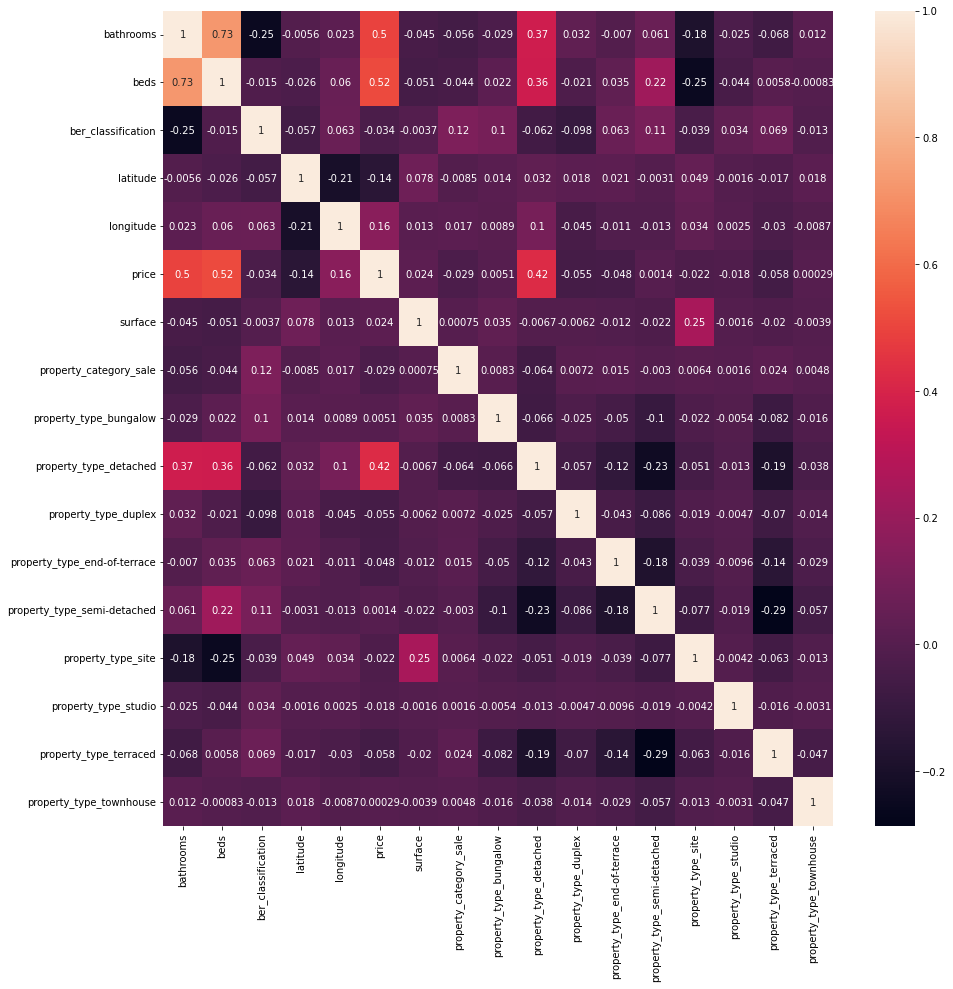

In [16]:
#Check the final training data
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True);

It is clear that price is closely correlated with both bedrooms and bathrooms. Price is also correlated with the category, detached. There is also a negative correlation between bathrooms and BER classification although not as strong.

In [17]:
#Final check for nulls
print(df_train.isna().sum())

bathrooms                       0
beds                            0
ber_classification              0
latitude                        0
longitude                       0
price                           0
surface                         0
property_category_sale          0
property_type_bungalow          0
property_type_detached          0
property_type_duplex            0
property_type_end-of-terrace    0
property_type_semi-detached     0
property_type_site              0
property_type_studio            0
property_type_terraced          0
property_type_townhouse         0
dtype: int64


All fields are not complete - no null/empty values

### Check distribution and remove outliers

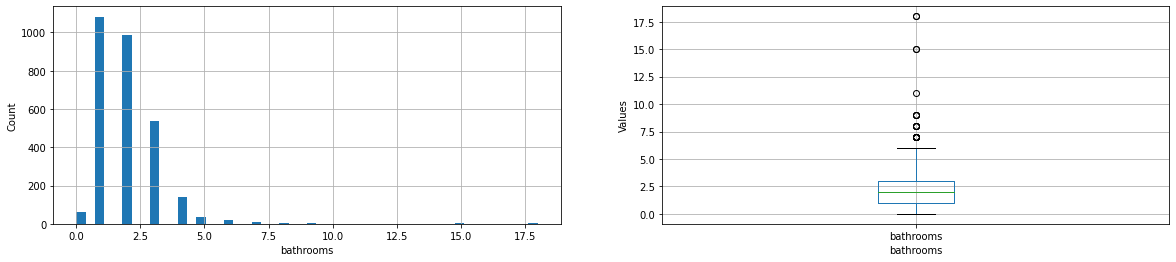

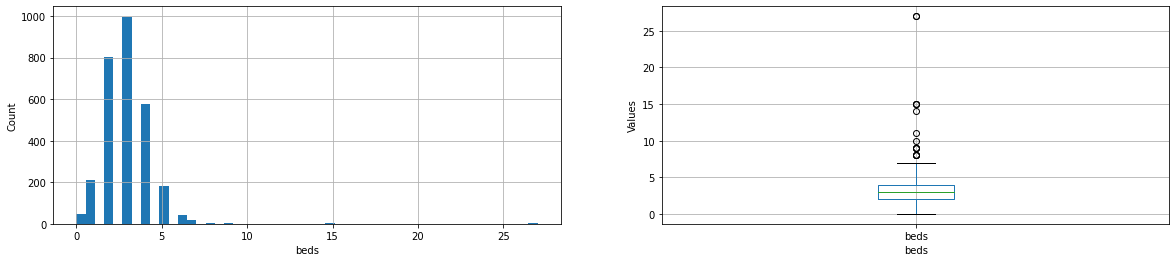

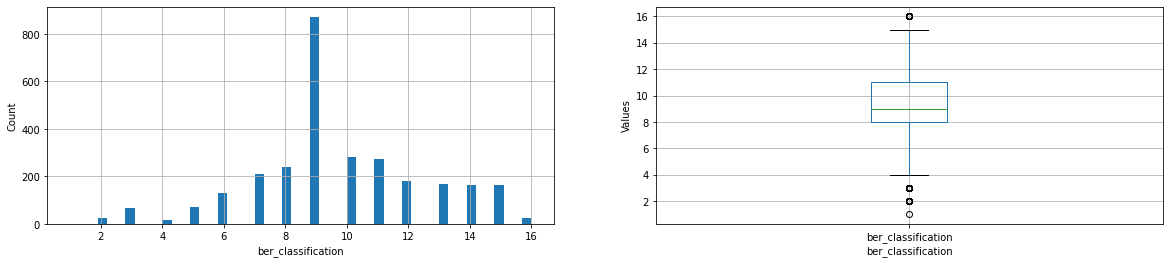

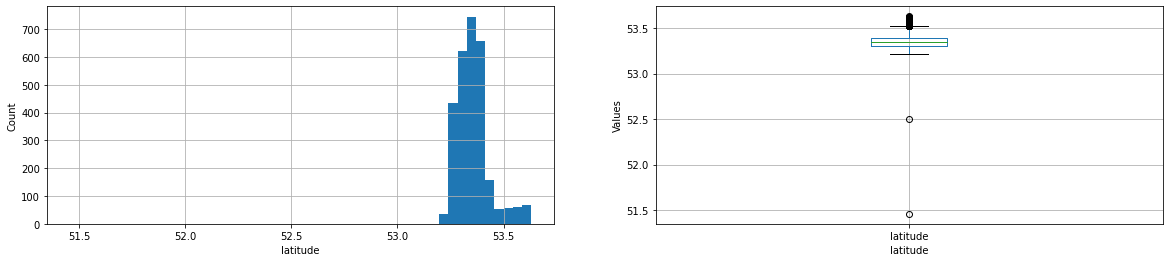

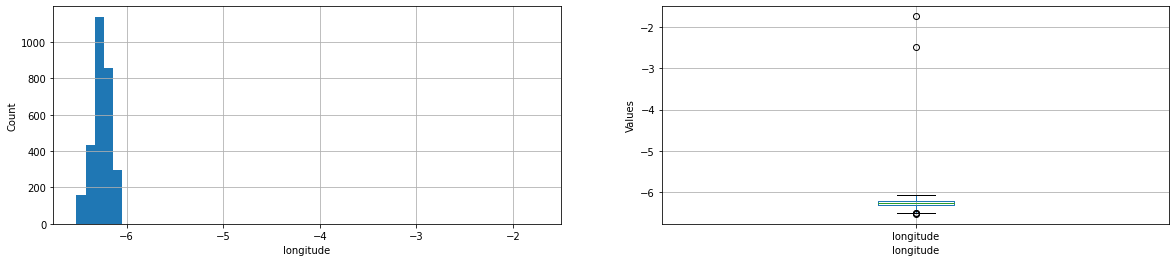

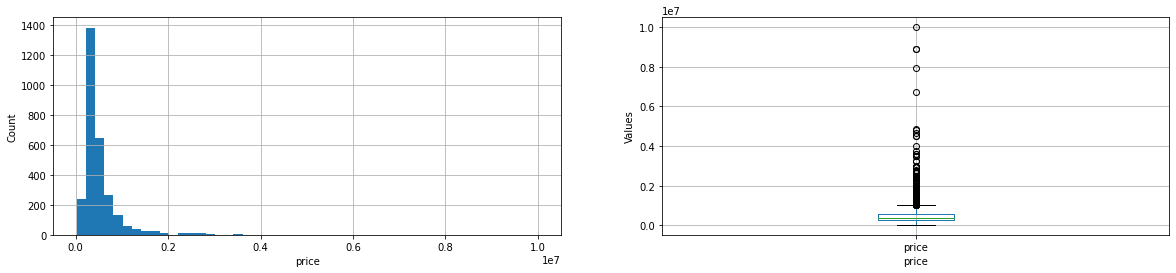

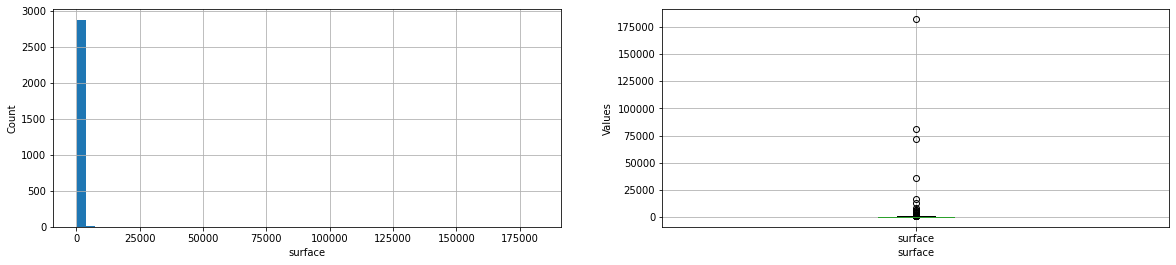

In [18]:

from pandas.api.types import is_numeric_dtype

for column in df_train:
  #ignore the encoded property columns
  if is_numeric_dtype(df_train[column]) and 'property_' not in column:
    plotColumn(df_train,column)

There are a number of outliers in the various columns, these will be removed:

In [19]:
#Latitude has two outliers < 53 - remove them
df_train.drop(df_train[df_train['latitude'] < 53].index, inplace=True)

#Longitude has two outliers > -4 - remove them
df_train.drop(df_train[df_train['longitude'] > -4].index, inplace=True)

#Bathroom has several outliers > 10 - remove them
df_train.drop(df_train[df_train['bathrooms'] > 10].index, inplace=True)

#Bedroom has one outlier > 20
df_train.drop(df_train[df_train['beds'] > 20].index, inplace=True)

#Surface has three outliers > 50000
df_train.drop(df_train[df_train['surface'] > 50000].index, inplace=True)

### Train dataset

We will now separate the price column as our output

In [20]:

#Remove price (y) from training data
X = df_train.drop('price', axis=1).values

#Y is the house price we are trying to determine
y = df_train['price']

In [21]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [22]:

import math
def get_error(actual, predicted):
   return math.sqrt(np.power((actual-predicted), 2).mean())

from sklearn.linear_model import LogisticRegression
#Linear regression
reg = LogisticRegression()
reg.fit (X_train,y_train)
y_pred=reg.predict(X_test)

#Get the error rate against test data
e = reg.score(X_test, y_pred)
error=get_error(y_test, y_pred)

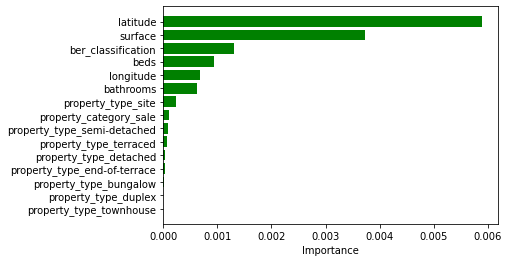

In [23]:
# get importance
importance = abs(reg.coef_[0])
indices = np.argsort(importance)[-15:]

features = df_train.drop('price', axis=1).columns
plt.barh(range(len(indices)), importance[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.show()

### Test dataset

In [24]:
df_test = pd.read_csv(testing_file)
print(describe_data("df_test",df_test))

Name:df_test
Shape:(500, 16)
Head:
      ad_id      area  bathrooms  beds ber_classification  county                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Expected Cost dataset

In [25]:
df_cost = pd.read_csv(cost_file)
print(describe_data("df_cost",df_cost))

Name:df_cost
Shape:(500, 2)
Head:
         Id  Expected
0  12373510  875000.0
1  12422623  355000.0
2  12377408  440000.0

Describe:
                 Id      Expected
count  5.000000e+02  5.000000e+02
mean   1.231695e+07  5.810356e+05
std    1.485832e+05  6.009194e+05
min    1.130615e+07  8.500000e+04
25%    1.228617e+07  2.950000e+05
50%    1.237964e+07  4.250000e+05
75%    1.240544e+07  5.950000e+05
max    1.242809e+07  5.750000e+06
-----------------------------------------------------------------------




# METHOD

## Full Model
We will select a subset of features for the baseline model.

In [26]:
featrain = ['beds','bathrooms','latitude','longitude','surface','price']
# dropna: remove missing values
df_subset_train = df_train[featrain].dropna(axis=0)

featest = ['beds','bathrooms','latitude','longitude','surface']
df_subset_test  =  df_test[featest].dropna(axis=0)

# cost
df_subset_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [27]:
df_subset_train.head(10)

beds  bathrooms   latitude  longitude     surface      price
15   5.0        3.0  53.400454  -6.445730  321.000000   935000.0
26   4.0        4.0  53.316410  -6.385214  144.000000   485000.0
27   5.0        3.0  53.401414  -6.446634  321.000000   935000.0
35   5.0        5.0  53.375377  -6.056749  312.000000  1475000.0
38   2.0        2.0  53.372130  -6.338466   83.000000   410000.0
40   4.0        3.0  53.451875  -6.199424  318.851787   525000.0
42   5.0        4.0  53.275379  -6.282236  280.000000  1295000.0
59   1.0        1.0  53.353395  -6.458716  318.851787   600000.0
60   5.0        2.0  53.375467  -6.062246  202.000000   980000.0
61   3.0        2.0  53.246732  -6.174917  150.000000   850000.0

In [28]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


There are no missing values in the selected data, moving forwards.

In [29]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_subset_cost.Expected.values

In [30]:
Xs_train[10]

array([  5.       ,   5.       ,  53.2373693,  -6.1314765, 656.       ])

We will now scale the data to give each column values in the 0 to 1 range.

In [31]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
print(Xss_test)

Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

[[ 4.00000000e+00  2.00000000e+00  5.35668810e+01 -6.10114800e+00
   1.42000000e+02  2.86941074e+03]
 [ 3.00000000e+00  2.00000000e+00  5.33629920e+01 -6.45290900e+00
   1.14000000e+02  2.84760892e+03]
 [ 4.00000000e+00  3.00000000e+00  5.34541980e+01 -6.26296400e+00
   1.72000000e+02  2.85735128e+03]
 ...
 [ 3.00000000e+00  1.00000000e+00  5.33916190e+01 -6.20515700e+00
   1.05000000e+02  2.85066498e+03]
 [ 4.00000000e+00  2.00000000e+00  5.33605780e+01 -6.18370100e+00
   1.30000000e+02  2.84735128e+03]
 [ 2.00000000e+00  2.00000000e+00  5.33668270e+01 -6.24832900e+00
   7.10000000e+01  2.84801822e+03]]


In [32]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 5,447.3


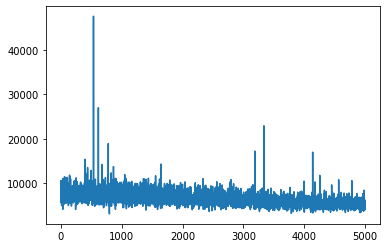

In [33]:
#number of iterations of the algorithms
iter = 5000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [34]:
#Get the posterior
posterior = approximation.sample(5000)

In [35]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  211097.85383160878
MAPE =  0.2859491719126451


## Clustering

### Determine num of clusters
Use the elbow method to determine best number of clusters.
Plot number of clusters against sum of squares.

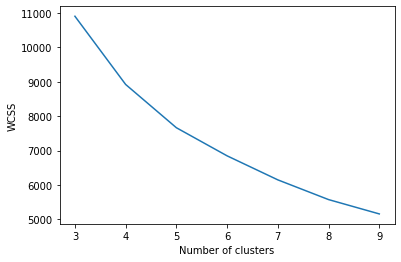

In [36]:
from sklearn import cluster

k_list=np.arange(3,10)
wcss=[]
for k in k_list:
    output = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(Xn_train)
    wcss.append(output.inertia_)

plt.plot(k_list,wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the chart, there appears to be a slight elbow between 5 and 6 clusters

### Full Model
We will process the data based on 6 clusters. initially using Gaussian Mixture with the full dataset

In [37]:
num_clusters = 6
cluster_list = np.arange(0,num_clusters)

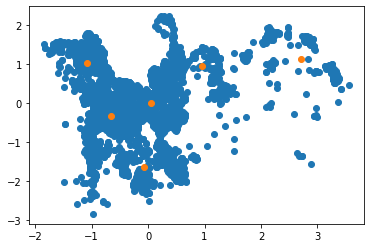

In [38]:
# training gaussian mixture model with 6 clusters
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=num_clusters)
# clustering by features lat/lon
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

From a visual check the clusters appear to be well spread and intuitive

### Clusters

The data will now be seperated into the preferred number of clusters

In [39]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 282, 1: 1008, 2: 410, 3: 460, 4: 526, 5: 196}

In [40]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 43, 1: 166, 2: 84, 3: 56, 4: 107, 5: 44}

In [41]:
Xn=[]
Xtestn=[]
ylog=[]
yscaler=[]
yn=[]

for c in cluster_list:
  Xn.append(Xn_train[clusters_train==c,:])
  Xtestn.append(Xn_test[clusters_test==c,:])

  ylog.append(np.log(ys_train.astype('float')[clusters_train==c,:]))
  yscaler.append(StandardScaler().fit(ylog[c]))
  yn.append(yscaler[c].transform(ylog[c]))

## Piecewise Model

We will now fit the data for each individual cluster. For each of these we will use the posterior to calculate MAE and MAPE.

In [42]:
#Generic function to get the posterior and prediction
def getPosterior(Xn,yn,iter,Xn_test,y_test,yscaler,clusternum):
  with pm.Model() as model:
    # prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    # we have a beta for each column of Xn0
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn.shape[1])
    # prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    # linear regression relationship
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn.T)
    # likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn[:,0])
  with model:
    approximation = pm.fit(40000,method='advi')

  #Get the posterior   
  posterior = approximation.sample(5000)

  # prediction
  ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
  y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
  mae=(np.mean(abs(y_pred_BLR - y_test[clusters_test==clusternum])))
  mape=(np.mean(abs(y_pred_BLR - y_test[clusters_test==clusternum]) / y_test[clusters_test==clusternum]))

  return posterior, mae, mape



In [43]:
posterior_list=[]
mae_list=[]
mape_list=[]
for c in cluster_list:
  p, mae, mape = getPosterior(Xn[c],yn[c],40000,Xtestn[c],y_test,yscaler[c],c)
  posterior_list.append(p)
  mae_list.append(mae)
  mape_list.append(mape)
  print(f"Model {c}")
  print(f"MAE: {mae}")
  print(f"MAPE: {mape}")
  print(f"Posterior:{posterior}")
  print("------------------------------------------\n")

Finished [100%]: Average Loss = 276.15


Model 0
MAE: 147537.7290634222
MAPE: 0.23109295100536925
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



Finished [100%]: Average Loss = 992.66


Model 1
MAE: 143545.3665346105
MAPE: 0.23859692705354707
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



Finished [100%]: Average Loss = 372.81


Model 2
MAE: 233587.84708005885
MAPE: 0.2343084322568902
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



Finished [100%]: Average Loss = 512.9


Model 3
MAE: 123811.6432815107
MAPE: 0.2390213895862105
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



Finished [100%]: Average Loss = 459.65


Model 4
MAE: 263011.7798148541
MAPE: 0.223759389754702
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



Finished [100%]: Average Loss = 244.03


Model 5
MAE: 88116.56160602745
MAPE: 0.2285769284178505
Posterior:<MultiTrace: 1 chains, 5000 iterations, 4 variables>
------------------------------------------



##Simulations

In [44]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

In [45]:
#Generic function for simulations
def plot_simulation(yscaler,posterior,Xn,ylog):
  Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn,  nsamples=200))
  for i in range(Ypred.shape[0]):
      az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
  az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
  az.plot_dist(ylog,label='true observations');
  plt.legend()
  plt.xlabel("log(y) - output variable")
  plt.ylabel("density plot");
  plt.show()

Simulation for model 0


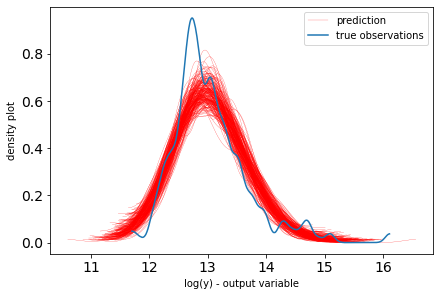

Simulation for model 1


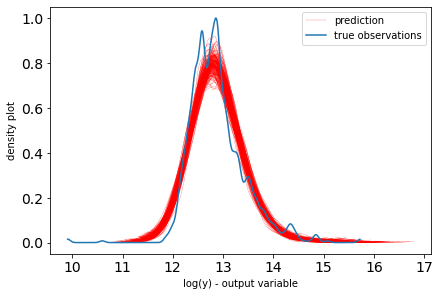

Simulation for model 2


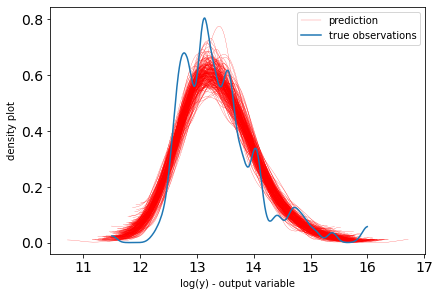

Simulation for model 3


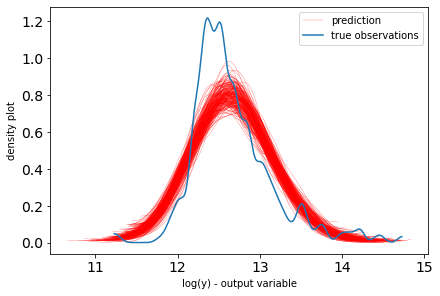

Simulation for model 4


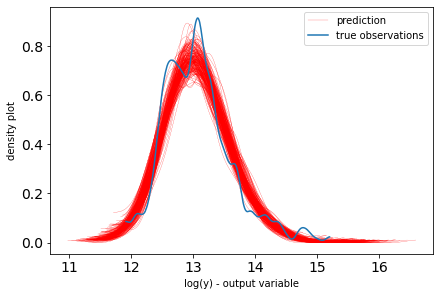

Simulation for model 5


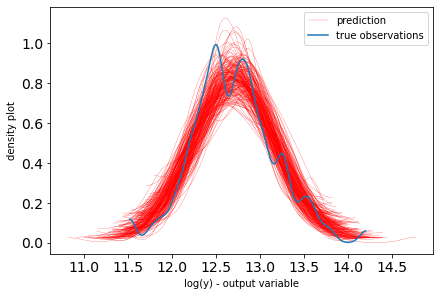

In [46]:
#Plot simulation for each cluster
for c in cluster_list:
  print(f"Simulation for model {c}")
  plot_simulation(yscaler[c],posterior_list[c],Xn[c],ylog[c])

## Overall

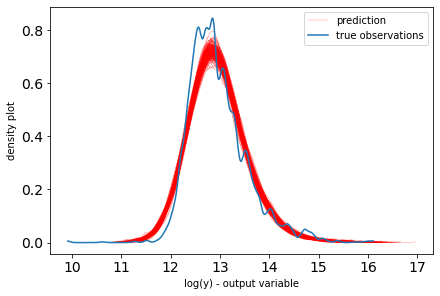

In [47]:
# posteriors
Ypred_list=[]
for c in cluster_list:
  Ypred_list.append(ppc(posterior_list[c]['alpha'],posterior_list[c]['beta'],posterior_list[c]['sigma_n'],Xn[c],  nsamples=200))

# simulation
Ypred = np.hstack([ 
                   yscaler[0].inverse_transform(Ypred_list[0]),
                 yscaler[1].inverse_transform(Ypred_list[1]),
                 yscaler[2].inverse_transform(Ypred_list[2]),
                 yscaler[3].inverse_transform(Ypred_list[3]),
                 yscaler[4].inverse_transform(Ypred_list[4]),
                 yscaler[5].inverse_transform(Ypred_list[5])])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack(y for y in ylog)
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

The model is now applied to the test dataset



In [48]:
def testset(cluster_num,yscaler,posterior,Xtestn,y_test):
  y_pred_BLR = np.exp(yscaler.inverse_transform(np.mean(posterior['alpha']) 
              + np.dot(np.mean(posterior['beta'],axis=0), Xtestn.T)))
  mae=(np.mean(abs(y_pred_BLR - y_test[clusters_test==cluster_num])))
  mape=(np.mean(abs(y_pred_BLR - y_test[clusters_test==cluster_num]) / y_test[clusters_test==cluster_num]))

  print(f"Size Cluster{cluster_num}:", np.sum(clusters_test==cluster_num))
  print(f"MAE Cluster{cluster_num}={mae}")
  print(f"MAPE Cluster{cluster_num}={mape}")
  print("-------------------------\n")
  
  mae=abs(y_pred_BLR - y_test[clusters_test==cluster_num])
  mape = abs(y_pred_BLR - y_test[clusters_test==cluster_num]) / y_test[clusters_test==cluster_num]

  return mae, mape

In [49]:
joint_mae_list=[]
joint_mape_list=[]
for c in cluster_list:
  joint_mae, joint_mape = testset([c],yscaler[c],posterior_list[c],Xtestn[c],y_test)
  joint_mae_list.append(joint_mae)
  joint_mape_list.append(joint_mape)

Size Cluster[0]: 43
MAE Cluster[0]=147537.7290634222
MAPE Cluster[0]=0.23109295100536925
-------------------------

Size Cluster[1]: 166
MAE Cluster[1]=143545.3665346105
MAPE Cluster[1]=0.23859692705354707
-------------------------

Size Cluster[2]: 84
MAE Cluster[2]=233587.84708005885
MAPE Cluster[2]=0.2343084322568902
-------------------------

Size Cluster[3]: 56
MAE Cluster[3]=123811.6432815107
MAPE Cluster[3]=0.2390213895862105
-------------------------

Size Cluster[4]: 107
MAE Cluster[4]=263011.7798148541
MAPE Cluster[4]=0.223759389754702
-------------------------

Size Cluster[5]: 44
MAE Cluster[5]=88116.56160602745
MAPE Cluster[5]=0.2285769284178505
-------------------------



In [50]:
# joint mae
joint_mae=np.hstack(j for j in joint_mae_list)
# joint mape
joint_mape=np.hstack(j for j in joint_mape_list)

# MAE
print("MAE=",np.mean(joint_mae))
# MAPE
print("MAPE=",np.mean(joint_mape))

MAE= 177493.74704763328
MAPE= 0.23322166492932958


### PPC on the Test set



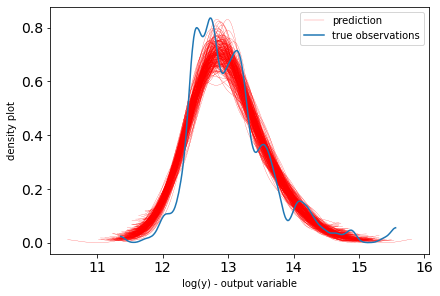

In [51]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred_test_list=[]
for c in cluster_list:
  Ypred_test_list.append(ppc(posterior_list[c]['alpha'],posterior_list[c]['beta'],posterior_list[c]['sigma_n'],Xtestn[c],  nsamples=200))




# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler[0].inverse_transform(Ypred_test_list[0]),
                 yscaler[1].inverse_transform(Ypred_test_list[1]),
                 yscaler[2].inverse_transform(Ypred_test_list[2]),
                 yscaler[3].inverse_transform(Ypred_test_list[3]),
                 yscaler[4].inverse_transform(Ypred_test_list[4]),
                 yscaler[5].inverse_transform(Ypred_test_list[5])])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY

The full model regression generated the below results:

MAE =  212101.81700197572
MAPE =  0.28491409435535675

The data was then analysed using KMeans clustering and an 'elbow' was observed between 5 and 6 clusters. 

The data was then split into 6 clusters and the piecewise regression was performed. The posterior was then used to calculate MAE and MAPE values for each. This resulted in the below outputs:

**Model 0**

MAE: 262747.5366309219
MAPE: 0.22428698544199457

**Model 1**

MAE: 87967.80881306803
MAPE: 0.2274801135344865

**Model 2**

MAE: 143428.77056749896
MAPE: 0.23912440728443388

**Model 3**

MAE: 234121.48928901486
MAPE: 0.23496499797579393

**Model 4**

MAE: 123774.63273960508
MAPE: 0.2388115624478864

**Model 5**

MAE: 147334.98355091244
MAPE: 0.23102453937483644

Each indivual model performed slightly better than the overall result, with models 0 and 1 performing best. 

The model was then used to generate predicted values for the test dataset. These were then compared with the actual values.

Overall comparison:

| Metric | Full Model | Piecewise Model |
| --- | --- | --- |
| MAE | 212101.8170 | 177493.7470 |
| MAPE | 0.2849 | 0.2332 |

As expected, with a more targetted approach, the piecewise model performed better with an approx 5% improvement.



## References

Dataquest.io 2021. Understanding Regression Error Metrics. Available at: https://www.dataquest.io/blog/understanding-regression-error-metrics/

Towardsdatascience.com 2021. Piecewise Linear Regression Model. What Is It and When Can We Use It? Available at: https://towardsdatascience.com/piecewise-linear-regression-model-what-is-it-and-when-can-we-use-it-93286cfee452



In [54]:
#Export PDF file
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ET5003_Etivity2_Morgan_lynch_8908079.ipynb')